# Demo Webcam

**imports and upload model**

In [1]:
UPLOAD_MODEL= True
path_dict="..\\demo-vqa-webcam\\BUTDA\\data\\dictionary.pkl"
path_label2ans = "..\\demo-vqa-webcam\\BUTDA\\data\\cache\\trainval_label2ans.pkl"

path_VGG = '../demo-vqa-webcam/BUTDA/saved_models/VGG_bidirect_model/model.pth'
h5path_features = 'img_features.h5'


In [2]:
import pickle as cPickle
import PySimpleGUI as sg
import matplotlib.pyplot as plt
import os
import json
import h5py
from tqdm import tqdm
from PIL import Image
import numpy as np
from torchvision import transforms
import torchvision.models as models
import torch
import cv2
from base_model import build_baseline0_newatt
from dataset import Dictionary, VQAFeatureDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\ProgramData\Anaconda3\envs\Assignment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if UPLOAD_MODEL:
    dictionary = Dictionary.load_from_file(path_dict)
    train_dset = VQAFeatureDataset("val", dictionary, isBERT=False)
    model = build_baseline0_newatt(train_dset,  1024, bidirectional= True)
    model.load_state_dict(torch.load(path_VGG), strict=False)
    model.eval()

loading dictionary from ..\demo-vqa-webcam\BUTDA\data\dictionary.pkl
loading features from h5 file
..\demo-vqa-webcam\BUTDA\data\val_VGG.h5


## Open webcam

In [4]:
label2ans= cPickle.load(open(path_label2ans, "rb"))
word2idx, idx2word = cPickle.load(open(path_dict, "rb"))
def run_prediction(model, features, question):
  with torch.no_grad():
        
        v= torch.from_numpy(features[:])
        v=v.unsqueeze(0)
        q_tok = tokenize_single(question).unsqueeze(0)
        pred = model(v, q_tok)
        top_preds_values, top_preds_labels = torch.topk(pred.squeeze(), 3)
        top_preds_values = torch.nn.functional.softmax(
            top_preds_values, dim=-1
        ).tolist()
        top_preds_labels = [label2ans[idx] for idx in top_preds_labels]
        confidences = dict()
        index = 0
        for i in top_preds_labels:
          confidences[i] = top_preds_values[index]
          index = index +1
       
        best_pred = label2ans[pred.squeeze().argmax().item()]

        return pred , best_pred, confidences

def tokenize(sentence, add_word=False):
    sentence = sentence.lower()
    sentence = sentence.replace(",", "").replace("?", "").replace("'s", " 's")
    words = sentence.split()
    tokens = []
    for w in words:
        tokens.append(word2idx[w])
    return tokens

def tokenize_single(question, max_length=14):
    tokens = tokenize(question, False)
    tokens = tokens[:max_length]
    if len(tokens) < max_length:
        # pad in front of the sentence
        padding = [len(word2idx)] * (max_length - len(tokens))
        tokens = padding + tokens
    assert len(tokens) == max_length, "length not corresponding"
    return torch.tensor(tokens)


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


building the h5 file...
done <Closed HDF5 file>


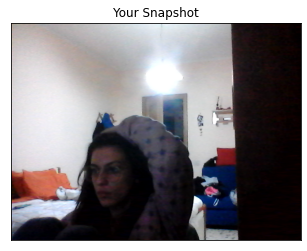

In [17]:
def VGG_extractor(image_path, feature_extractor, convert_tensor):
    return feature_extractor(convert_tensor(image_path).to(device))

def resize_image(img):
  img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
  dim = (224, 224)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized 

def extraction(extract_for_train=True, extractor='VGG'):
    assert extractor in ['SIFT', 'ViT', 'VGG']
    vgg16 = models.vgg16(pretrained=True)
    vgg16_fe = vgg16.features.to(device)
    descriptors = VGG_extractor(resize_image('newphoto.png'), vgg16_fe, transforms.ToTensor()).reshape(512,49).cpu().detach().numpy()
    print("building the h5 file...")
    with h5py.File(h5path_features,"w") as hdf:
        hdf.create_dataset('image_features', data=np.array(descriptors))
        hdf.close()                          # close the file
    print("done", hdf)
  
def main():
    sg.theme("DarkBlue13")

    # Define the window layout
    layout = [
        [sg.Text("OpenCV Demo", size=(60, 1), justification="center")],
        [sg.Image(filename="", key="-IMAGE-")],
        [sg.Radio("None", "Radio", True, size=(10, 1))],
        [
            sg.Radio("Threshold", "Radio", size=(10, 1), key="-THRESH-"),
            sg.Slider(
                (0, 255),
                128,
                1,
                orientation="h",
                size=(40, 15),
                key="-THRESH SLIDER-",
            ),
        ],
        [
            sg.Radio("Canny", "Radio", size=(10, 1), key="-CANNY-"),
            sg.Slider(
                (0, 255),
                128,
                1,
                orientation="h",
                size=(20, 15),
                key="-CANNY SLIDER A-",
            ),
            sg.Slider(
                (0, 255),
                128,
                1,
                orientation="h",
                size=(20, 15),
                key="-CANNY SLIDER B-",
            ),
        ],
        [
            sg.Radio("Blur", "Radio", size=(10, 1), key="-BLUR-"),
            sg.Slider(
                (1, 11),
                1,
                1,
                orientation="h",
                size=(40, 15),
                key="-BLUR SLIDER-",
            ),
        ],
        [
            sg.Radio("Hue", "Radio", size=(10, 1), key="-HUE-"),
            sg.Slider(
                (0, 225),
                0,
                1,
                orientation="h",
                size=(40, 15),
                key="-HUE SLIDER-",
            ),
        ],
        [
            sg.Radio("Enhance", "Radio", size=(10, 1), key="-ENHANCE-"),
            sg.Slider(
                (1, 255),
                128,
                1,
                orientation="h",
                size=(40, 15),
                key="-ENHANCE SLIDER-",
            ),
        ],
        [
            sg.Button("Take a Snapshot", size=(15, 1)),
            sg.Button("Exit", size=(10, 1))
        ]
    ]

    window = sg.Window("Demo VQA", layout, location=(800, 400), font=('Helvetica', 10))
    cap = cv2.VideoCapture(0)
    layout_2 = [  [sg.Text('VQA DEMO',size=(60, 1), justification="center")],
            [sg.Text('Enter your question'), sg.InputText(), sg.Button('Send')],
            [sg.Text("", size=(0, 1), key='OUTPUT')],
            [ sg.Button('Cancel')] ]

    window_2 = sg.Window('Enter your question', layout_2, font=('Helvetica', 10))


    while True:
        event, values = window.read(timeout=20)
        if event == "Exit" or event == sg.WIN_CLOSED or event == 'Cancel':
            cap.release()
            break

        ret, frame = cap.read()

    
        if values["-THRESH-"]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)[:, :, 0]
            frame = cv2.threshold(
                frame, values["-THRESH SLIDER-"], 255, cv2.THRESH_BINARY
            )[1]
        elif values["-CANNY-"]:
            frame = cv2.Canny(
                frame, values["-CANNY SLIDER A-"], values["-CANNY SLIDER B-"]
            )
        elif values["-BLUR-"]:
            frame = cv2.GaussianBlur(frame, (21, 21), values["-BLUR SLIDER-"])
        elif values["-HUE-"]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            frame[:, :, 0] += int(values["-HUE SLIDER-"])
            frame = cv2.cvtColor(frame, cv2.COLOR_HSV2BGR)
        elif values["-ENHANCE-"]:
            enh_val = values["-ENHANCE SLIDER-"] / 40
            clahe = cv2.createCLAHE(clipLimit=enh_val, tileGridSize=(8, 8))
            lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
            lab[:, :, 0] = clahe.apply(lab[:, :, 0])
            frame = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        imgbytes = cv2.imencode(".png", frame)[1].tobytes()
        window["-IMAGE-"].update(data=imgbytes)
        if event == "Take a Snapshot":             
            cap.release()

            cv2.imwrite("newphoto.png", frame)
            frame= cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            extraction(extract_for_train=False, extractor='VGG')
            window.close()
            while True:
                event2, values_2 = window_2.read()
                if event2 == sg.WIN_CLOSED or event2 == 'Cancel':
                    break
                elif event2=="Send":
                    question=values_2[0]
                    hf = h5py.File(h5path_features, "r")
                    features = hf.get("image_features")
                    text= run_prediction(model,features , question)
                    print(values_2[0], text[2])
                    window_2['OUTPUT'].update(value=text[1])
            window_2.close()
       
        
            plt.title('Your Snapshot')
            plt.xticks([])
            plt.yticks([])
            plt.imshow(frame)



main()